In [2]:
import numpy as np
import json
import matplotlib.pyplot as plt 
from scipy.spatial import Delaunay 
import skimage as sk
import scipy as sci
from scipy.interpolate import RegularGridInterpolator
import skimage.io as io
from scipy import ndimage
from matplotlib.path import Path
from PIL import Image, ImageDraw


In [14]:
def calcH(im1Pt, im2Pt):
    """
        Finds the H transformation matrix using least squares for im1 and im2 points.

        Args:
            im1Pt (Nx3 np.array): homogenous corrdinates of im1 correspondances
            im2Pt (Nx3 np.array): homogenous corrdinates of im2 correspondances
        
        Returns:
            h (3x3 np.array): Linear solution of the transformation matrix
    """
    #Initialize A matrix
    A = np.empty((im1Pt.shape[0] * 2, 8))
    b = np.empty((im1Pt.shape[0] * 2, 1))

    # Populate A and b with x and y
    for i in range(im2Pt.shape[0]):
        b[i*2] = im2Pt[i,0]
        b[i*2+1] = im2Pt[i,1]
        A[i*2] = np.array([im1Pt[i, 0], im1Pt[i, 1], 1, 0, 0, 0, -im1Pt[i, 0] * im2Pt[i,0],  -im1Pt[i, 1] * im2Pt[i,0]])
        A[i*2 + 1] = np.array([0, 0, 0, im1Pt[i, 0], im1Pt[i, 1], 1, -im1Pt[i, 0] * im2Pt[i,1],  -im1Pt[i, 1] * im2Pt[i,1]])

    # print(b)
    # print(A)
    # Solve for least squares
    sol = np.linalg.lstsq(A, b)[0]
    # print(sol)
    # print(sol[0:3, :].T)

    h = np.empty((3, 3))

    h[0] = sol[0:3, :].T
    h[1] = sol[3:6, :].T
    h[2, 0:2] = sol[6: , :].T
    h[2,2] = 1
    
    # Add bottom row
    return h

def transformPoints(points, H):
    """
        Divides out W term in transformed points

        Args:
            points (Nx2 np.array): x,y coordinates of points
            H (3x3 np.array): Transformation Matrix
        
        Returns:
            result (Nx2 np.array): Original points transformed by H
    """
    ones = np.ones((points.shape[0],1))
    homogPoints = np.append(points, ones, 1)
    transformedPoints = np.array([H@p for p in homogPoints])
    transformedPoints  = transformedPoints / transformedPoints[:, 2, None]
    return transformedPoints[:, 0:2]

def translateIm(corners, im):
    """
        Adjust corners and pads img so that the lowest index is 0.

        Args:
            corners (4x2 np.array): Bounds of the corners of warped img.
            im (NxWx3 np.array): im
        
        Returns:
            shiftedCorners, xshift, yshift, shiftedImg
    """
    minBounds = np.min(corners, axis=0)
    shiftedCorners = corners.copy()
    yshift =  int(abs(min(0, np.floor(minBounds[0]))))
    xshift = int(abs(min(0, np.floor(minBounds[1]))))
    shiftedCorners[:, 0] += yshift
    shiftedCorners[:, 1] += xshift
    maxBounds = np.max(shiftedCorners, axis=0)
    print(maxBounds)
    print(maxBounds[1] - im.shape[0])
    im2Padded = np.pad(im, ((abs(min(0, int(np.floor(minBounds[1])))), int(max(np.ceil(maxBounds[1] - im.shape[0] - abs(min(0, int(np.floor(minBounds[1]))))), 0))), (abs(min(0,int(np.floor(minBounds[0])))), int(max(np.ceil(maxBounds[0] - im.shape[1] - abs(min(0,int(np.floor(minBounds[0]))))), 0))), (0,0)))
    return shiftedCorners, int(abs(min(0, np.floor(minBounds[0])))), int(abs(min(0, np.floor(minBounds[1])))), im2Padded

In [ ]:
def makeMask(corners, paddedIm):
    polygonCoords = np.stack((corners[:, 0], corners[:, 1])).T
    polygonCoords = polygonCoords.flatten().tolist()
    img = Image.new("L", (paddedIm.shape[1], paddedIm.shape[0]), 0)
    ImageDraw.Draw(img).polygon(polygonCoords, outline=1, fill=1)
    mask = np.array(img)
    plt.imsave("./results/mask.jpg", mask)
    return mask

def createInterpolater(im):
    y, x, c = np.arange(0, im.shape[0]), np.arange(
        0, im.shape[1]), np.arange(0, 3)
    interp = RegularGridInterpolator((y, x, c), im1)
    return interp

def fillMask(
    warpIm,
    paddedImg,
    interp,
    inverseH,
    maskPoints,
    xshift,
    yshift,
    blend=False,
    blendRatio=0,
):
    originalMaskPoints = maskPoints.copy()
    originalMaskPoints[:, 0] -= yshift
    originalMaskPoints[:, 1] -= xshift
    maskPointsXY = np.stack(
        (originalMaskPoints[:, 1], originalMaskPoints[:, 0]), axis=1
    )
    # maskPointsXY = maskPointsXY[maskPointsXY[:, 1].argsort()]
    fillCoords = transformPoints(maskPointsXY, inverseH)
    fillCoords = np.stack((fillCoords[:, 1], fillCoords[:, 0]), axis=1)
    fillCoords[:, 1] = np.clip(fillCoords[:, 1], 0, warpIm.shape[1] - 1)
    fillCoords[:, 0] = np.clip(fillCoords[:, 0], 0, warpIm.shape[0] - 1)
    colorChannel = np.empty((fillCoords.shape[0], 1))
    fillCoords = np.append(fillCoords, colorChannel, axis=1)

    # fillCoords = fillCoords[fillCoords[:, 1].argsort()]
    # print(fillCoords)
    colorChannel = np.empty((colorChannel.shape[0], 1))
    changeCoords = np.append(maskPoints, colorChannel, axis=1).astype(np.int16)
    # changeCoords = changeCoords[changeCoords[:, 1].argsort()]
    result = paddedImg.copy()
    for i in range(0, 3):
        fillCoords[:, 2] = i
        warpedvalues = interp(fillCoords)
        # print(changeCoords[:, 2])
        changeCoords[:, 2] = i
        changeCoordTuple = list(map(tuple, changeCoords.tolist()))
        # print(changeCoords[:,1])
        # print(np.max(changeCoords[:, 1]))
        # print(scalingArrayX)

        if blend:
            scalingArrayX = changeCoords[:, 1] - np.min(changeCoords[:, 1])
            scalingArrayX = scalingArrayX / np.max(scalingArrayX)
            # scalingArrayY = np.median(changeCoords[:, 0])
            # scalingArrayY = np.abs((changeCoords[:, 0] - scalingArrayY))
            # print(np.percentile(scalingArrayY, 90))
            # scalingArrayY = np.where(scalingArrayY > np.percentile(scalingArrayY, 90), 1 - (scalingArrayY / np.max(scalingArrayY)), 1)
            # print(np.min(scalingArrayY), np.max(scalingArrayY))
            scalingArrayXY = 1 - scalingArrayX * 1  # scalingArrayY
            scalingArrayXY = (scalingArrayXY - np.min(scalingArrayXY)) / np.max(
                scalingArrayXY
            )

            print(scalingArrayXY)
            result[tuple(np.transpose(changeCoordTuple))] = (
                result[tuple(np.transpose(changeCoordTuple))] * scalingArrayXY
                + warpedvalues * (1 - scalingArrayXY)
            ).astype(np.uint8)
            result = np.clip(result, 0, 255)
        else:
            result[tuple(np.transpose(changeCoordTuple))] = warpedvalues
    return result


def createWarp(warpIm, paddedImg, shiftedCorners, inverseH, xshift, yshift, blendRatio):
    interp = createInterpolater(warpIm)
    mask = makeMask(shiftedCorners, paddedImg)
    imSum = np.sum(paddedImg, axis=2)
    maskPoints = np.argwhere((mask == 1) & (imSum == 0))
    maskPoints = maskPoints[maskPoints[:, 1].argsort()]
    maskPointsOverlap = np.argwhere((mask == 1) & (imSum != 0))
    maskPointsOverlap = maskPointsOverlap[maskPointsOverlap[:, 1].argsort()]
    result = fillMask(warpIm, paddedImg, interp, inverseH,
                      maskPoints, xshift, yshift)
    result = fillMask(
        warpIm,
        result,
        interp,
        inverseH,
        maskPointsOverlap,
        xshift,
        yshift,
        True,
        blendRatio,
    )

    return result

In [23]:
im1 = ndimage.rotate(io.imread('./imgs/houses1.jpg'), 0)
im2 = ndimage.rotate(io.imread("./imgs/houses2.jpg"), 0)
with open('./imgs/houses1_houses2.json') as jsonFile:
    keyPoints = json.load(jsonFile)
im1Pts = np.array(keyPoints["im1Points"])
im2Pts = np.array(keyPoints["im2Points"])

(np.float64(-0.5), np.float64(999.5), np.float64(749.5), np.float64(-0.5))

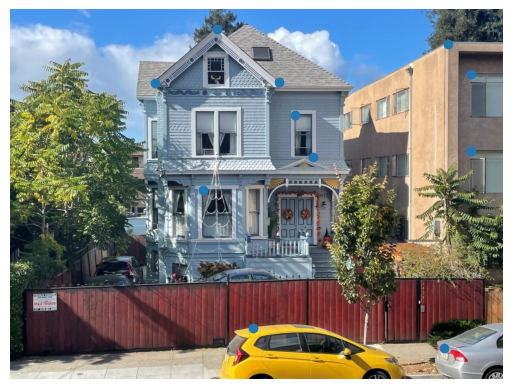

In [24]:
plt.imshow(im1)
plt.plot(im1Pts[:, 0], im1Pts[:, 1], "o")
plt.axis('off')
# plt.savefig("./results/treePoints.jpg", bbox_inches='tight')

In [25]:
def warpPipeline(im1Pts, im2Pts):
    fig, axs = plt.subplots(1, 2)
    H = calcH(im1Pts, im2Pts)
    inverseH = np.linalg.inv(H)

    warpedCorner0 = np.array([0, 0])
    warpedCorner1 = np.array([0, im1.shape[0]-1])
    warpedCorner2 = np.array([im1.shape[1]-1, 0])
    warpedCorner3 = np.array([im1.shape[1]-1, im1.shape[0]-1])
    corners = np.array([warpedCorner0, warpedCorner1, warpedCorner3, warpedCorner2])

    transformedCorners = transformPoints(corners, H)
    shiftedCorners, xshift, yshift, im2Translated = translateIm(transformedCorners, im2)
    shiftedCorners.astype(np.int32)

    axs[0].axis("off")
    axs[0].imshow(im2Translated)
    axs[0].plot(shiftedCorners[:, 0], shiftedCorners[:, 1],  'o')

    result = createWarp(
        im1, im2Translated, shiftedCorners, inverseH, xshift, yshift, 0.5
    )

    axs[1].axis("off")
    axs[1].imshow(result)

    return result
    # axs[1, 0].axis("off")
    # axs[1, 0].imshow(im2)
    # axs[1, 0].plot(im2CoordGrey[point2, 1], im2CoordGrey[point2, 0], "bo")

    # axs[1, 1].axis("off")
    # axs[1, 1].imshow(descriptorim2Color[point2], cmap="grey")

    # plt.savefig("./resultsPt2/descriptors.jpg", bbox_inches="tight", dpi=1000)

[1051.87690576  824.75223481]
74.75223481467663
[1. 1. 1. ... 0. 0. 0.]
[1. 1. 1. ... 0. 0. 0.]
[1. 1. 1. ... 0. 0. 0.]


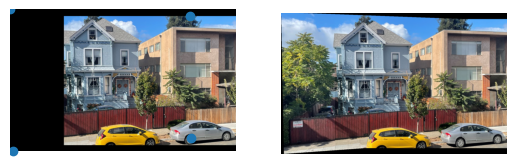

In [26]:
result = warpPipeline(im1Pts, im2Pts)

In [28]:
plt.imsave("./resultsPt2/im1/manual.jpg", result)

In [54]:
H = calcH(im1Pts, im2Pts)
inverseH = np.linalg.inv(H)

In [55]:
pPrime = transformPoints(im1Pts, H)

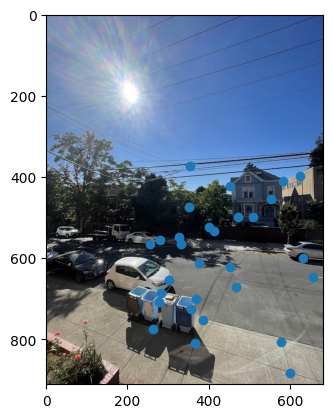

In [56]:
plt.imshow(im2)
plt.plot(pPrime[:, 0], pPrime[:, 1], "o")

In [57]:
warpedCorner0 = np.array([0, 0])
warpedCorner1 = np.array([0, im1.shape[0]-1])
warpedCorner2 = np.array([im1.shape[1]-1, 0])
warpedCorner3 = np.array([im1.shape[1]-1, im1.shape[0]-1])
corners = np.array([warpedCorner0, warpedCorner1, warpedCorner3, warpedCorner2])

In [58]:
corners

array([[  0,   0],
       [  0, 910],
       [682, 910],
       [682,   0]])

In [59]:
transformedCorners = transformPoints(corners, H)

In [60]:
testInverse = transformPoints(transformedCorners, inverseH)

In [62]:
shiftedCorners, xshift, yshift, im2Translated = translateIm(transformedCorners, im2)

[1289.87397011 1765.35924226]
854.3592422623915


In [63]:
shiftedCorners.astype(np.int32)

array([[ 213,  561],
       [ 241, 1261],
       [1289, 1765],
       [1211,    0]], dtype=int32)

In [64]:
im2Translated.shape

(1766, 1290, 3)

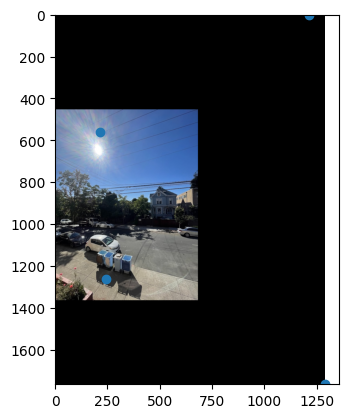

In [65]:
plt.gca().invert_yaxis()
plt.imshow(im2Translated)
plt.plot(shiftedCorners[:, 0], shiftedCorners[:, 1],  'o')
# plt.axis('off')
# plt.savefig("./results/shfitedCorners.jpg", bbox_inches='tight')

In [71]:
result = createWarp(im1, im2Translated, shiftedCorners, inverseH, xshift, yshift, 0.5)

[1. 1. 1. ... 0. 0. 0.]
[1. 1. 1. ... 0. 0. 0.]
[1. 1. 1. ... 0. 0. 0.]


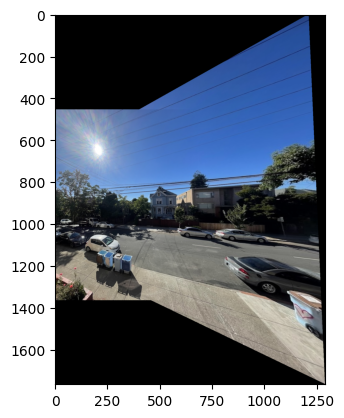

In [ ]:
plt.imshow(result)
# plt.imsave("./results/outsidePano.jpg", result)